In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Set the maximum column width to ensure complete values are shown
pd.set_option('display.max_rows', None)

# To see the entire columns present in dataframe
pd.set_option('display.max_columns', None)

# Set the maximum column width to ensure complete values are shown
pd.set_option('display.max_colwidth', None)

/var/folders/tx/jhszhvjs6z7d3g5nv45gvy_c0000gn/T/ipykernel_49574/261002273.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# since data is huge, setting record limit
records_to_fetch = 12000
data = pd.read_csv('resalys_query_booking_header_27_march.csv', nrows=records_to_fetch)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        12000 non-null  int64  
 1   Id                                12000 non-null  int64  
 2   BookingId                         12000 non-null  int64  
 3   BookingType                       12000 non-null  object 
 4   ResalysCampsiteId                 12000 non-null  int64  
 5   AcsiCampsiteId                    12000 non-null  int64  
 6   CampsiteCode                      11784 non-null  object 
 7   SuncampCampsiteId                 12000 non-null  int64  
 8   BookingDownPayment                12000 non-null  float64
 9   BookingDownPaymentPaid            12000 non-null  float64
 10  IsDownPaymentPaid                 12000 non-null  bool   
 11  BookingDownPaymentFinalDate       5920 non-null   object 
 12  Book

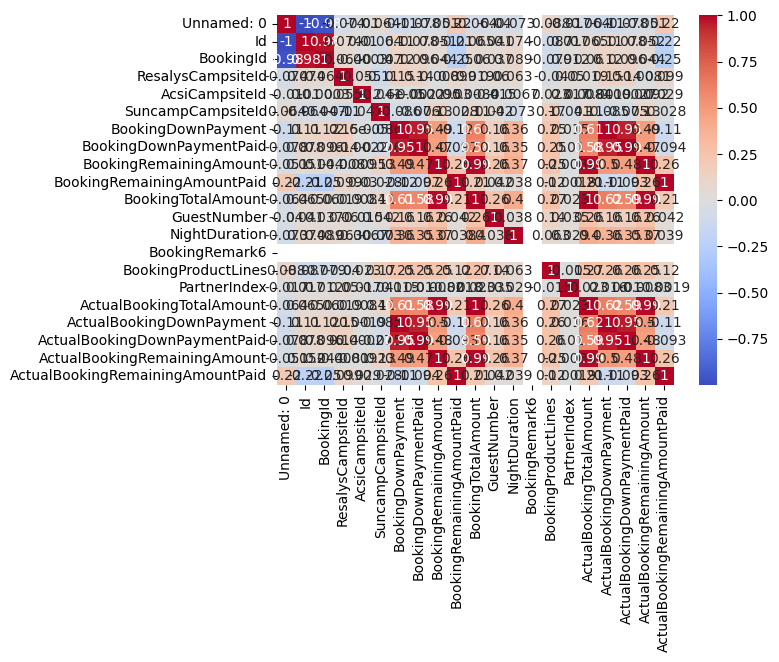

In [5]:
# EDA
data.info()
data.describe()

# Select only numeric columns for correlation matrix
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

In [7]:
# Cleaning Date Columns
# Function to parse dates with error handling
def parse_dates(date_series):
    return pd.to_datetime(date_series, errors='coerce')

# Convert date columns
data['ArrivalDate'] = parse_dates(data['ArrivalDate'])
data['DepartureDate'] = parse_dates(data['DepartureDate'])
data['CreatedOn'] = parse_dates(data['CreatedOn'])
data['ModifiedOn'] = parse_dates(data['ModifiedOn'])

# Drop rows with invalid dates if necessary
data = data.dropna(subset=['ArrivalDate', 'DepartureDate', 'CreatedOn'])

# Create new features
data['BookingLeadTime'] = (data['ArrivalDate'] - data['CreatedOn']).dt.days
data['StayDuration'] = (data['DepartureDate'] - data['ArrivalDate']).dt.days
data['BookingSeason'] = data['ArrivalDate'].dt.month % 12 // 3 + 1


/var/folders/tx/jhszhvjs6z7d3g5nv45gvy_c0000gn/T/ipykernel_49574/1899260236.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['BookingLeadTime'] = (data['ArrivalDate'] - data['CreatedOn']).dt.days
/var/folders/tx/jhszhvjs6z7d3g5nv45gvy_c0000gn/T/ipykernel_49574/1899260236.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['StayDuration'] = (data['DepartureDate'] - data['ArrivalDate']).dt.days
/var/folders/tx/jhszhvjs6z7d3g5nv45gvy_c0000gn/T/ipykernel_49574/1899260236.py:18: SettingWithCopyWar

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

# Select relevant features and target
features = ['BookingLeadTime', 'StayDuration', 'BookingSeason', 'GuestCountryCode']
target = 'BookingTotalAmount'

X = data[features]
y = data[target]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['BookingLeadTime', 'StayDuration']),
        ('cat', OneHotEncoder(), ['BookingSeason', 'GuestCountryCode'])
    ])

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Booking Total Amount')
plt.show()

# Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)


ValueError: Found unknown categories ['UG'] in column 1 during transform